In [187]:
#importing all the things

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import ast
import seaborn as sns
sns.set()

%matplotlib inline

In [188]:
#initializing constants
START_DATE = '12/10/2016'
NUM_OF_WEEKS = 6

In [189]:
def get_file_names(start,number): #generates weeknums
    files = []
    ds = dt.datetime.strptime(start,"%m/%d/%Y")
    file_name = (ds.strftime("%y%m%d"))
    files.append(int(file_name))
    for i in range(1,number+1):
        ds = ds+ dt.timedelta(days=7)
        file_name = int(ds.strftime("%y%m%d"))
        files.append(file_name)
    print (files)
    return files


def get_data_parse_dt(week_nums): #imports files from mta website
    url = "turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

def sortLinename(string):
    listLines = ''.join(sorted(string))
    return listLines

In [190]:
data = get_data_parse_dt(get_file_names(START_DATE,NUM_OF_WEEKS))
data.head()

[161210, 161217, 161224, 161231, 170107, 170114, 170121]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/03/2016,03:00:00,REGULAR,5944237,2014310
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/03/2016,07:00:00,REGULAR,5944254,2014328
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/03/2016,11:00:00,REGULAR,5944344,2014431
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/03/2016,15:00:00,REGULAR,5944588,2014508
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/03/2016,19:00:00,REGULAR,5945084,2014599


In [191]:
data.columns = [column.strip().lower() for column in data.columns] #formatting
data["date_time"] = pd.to_datetime(data.date + " " + data.time, format="%m/%d/%Y %H:%M:%S") #creating datetime column

In [192]:
data.linename = data.linename.apply(sortLinename) #standardizing linenames

In [193]:
data.date = pd.to_datetime(data.date)

In [194]:
oldline = ((data.station=='86 ST') & (data.linename=='456')) | ((data.station=='96 ST') & (data.linename=='6'))
#print (data[oldline].head())
newline = ((data.station=='86 ST-2 AVE') & (data.linename=='Q')) | ((data.station=='96 ST-2 AVE') & (data.linename=='Q'))
#print (data[newline].head())
control = (((data.station=='103 ST') | (data.station=='110 ST')) & (data.linename=='6'))
#print (data[control].head())
_77th456 = ((data.station=='77 ST') & (data.linename=='6'))

mask = ((oldline | newline | control | _77th456))
ourstations = (data[mask]).copy()

In [195]:
(ourstations
 .groupby(["c/a", "unit", "scp", "station", "date_time", "linename"])
 .entries.count()
 .reset_index()
 .sort_values("entries", ascending=False)).head(5)

,c/a,unit,scp,station,date_time,linename,entries
0,N701,R571,00-00-00,86 ST-2 AVE,2016-12-31 00:00:00,Q,1
13549,R250,R179,00-00-07,86 ST,2016-12-09 15:00:00,456,1
13556,R250,R179,00-00-07,86 ST,2016-12-10 19:00:00,456,1
13555,R250,R179,00-00-07,86 ST,2016-12-10 15:00:00,456,1
13554,R250,R179,00-00-07,86 ST,2016-12-10 11:00:00,456,1


In [ ]:
#ourstations = data.drop(["exits", "desc"], axis=1, errors="ignore")

In [196]:
ourstations["date"] = pd.to_datetime(ourstations["date"])

In [197]:
ourstations.sort_values(["c/a", "unit", "scp", "station", "date_time"],
                         inplace=True, ascending=False)

In [198]:
dailyData = (ourstations.groupby(["c/a", "unit", "scp", "station", "date", "linename"],as_index=False)
                        .entries.first())

In [199]:
dailyData[["prev_date", "prev_entries"]] = (dailyData.groupby(["c/a", "unit", "scp", "station", "linename"])
                                            ["date", "entries"].transform(lambda grp: grp.shift(1)))
dailyData.dropna(subset=["prev_date"], axis=0, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'date'

In [200]:
dailyData.head()

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries
1,N701,R571,00-00-00,86 ST-2 AVE,2017-01-01,Q,2103,2016-12-31,32.0
2,N701,R571,00-00-00,86 ST-2 AVE,2017-01-02,Q,4850,2017-01-01,2103.0
3,N701,R571,00-00-00,86 ST-2 AVE,2017-01-03,Q,8294,2017-01-02,4850.0
4,N701,R571,00-00-00,86 ST-2 AVE,2017-01-04,Q,12193,2017-01-03,8294.0
5,N701,R571,00-00-00,86 ST-2 AVE,2017-01-05,Q,15865,2017-01-04,12193.0


In [201]:
dailyData[dailyData["entries"] < dailyData["prev_entries"]]

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries


In [202]:
(dailyData
 .groupby(["c/a", "unit", "scp", "station"])['entries'].count()
    .reset_index().sort_values('entries',ascending=True))

,c/a,unit,scp,station,entries
0,N701,R571,00-00-00,86 ST-2 AVE,20
30,N702A,R572,01-03-04,96 ST-2 AVE,20
29,N702A,R572,01-03-03,96 ST-2 AVE,20
27,N702A,R572,01-03-01,96 ST-2 AVE,20
26,N702A,R572,01-03-00,96 ST-2 AVE,20
25,N702A,R572,01-00-04,96 ST-2 AVE,20
24,N702A,R572,01-00-03,96 ST-2 AVE,20
23,N702A,R572,01-00-02,96 ST-2 AVE,20
22,N702A,R572,01-00-01,96 ST-2 AVE,20
21,N702A,R572,01-00-00,96 ST-2 AVE,20


In [203]:
(dailyData
 .groupby(["c/a", "unit", "scp", "station"])['date'].count()
    .reset_index()['date'].value_counts())

48    55
20    31
Name: date, dtype: int64

In [204]:
(dailyData[dailyData["entries"] < dailyData["prev_entries"]]
    .groupby(["c/a", "unit", "scp", "station"])
    .size())

Series([], dtype: int64)

In [205]:
def get_daily_counts(row, max_counter):
    counter = abs(row["entries"] - row["prev_entries"])
    if counter > max_counter:
        print(row["entries"], row["prev_entries"])
        counter = min(row["entries"], row["prev_entries"])
    if counter > max_counter:
        return 0
    return counter

In [206]:
dailyData["daily_entries"] = dailyData.apply(get_daily_counts, axis=1, max_counter=20000)

In [207]:
dailyData.head(20)

,c/a,unit,scp,station,date,linename,entries,prev_date,prev_entries,daily_entries
1,N701,R571,00-00-00,86 ST-2 AVE,2017-01-01,Q,2103,2016-12-31,32.0,2071.0
2,N701,R571,00-00-00,86 ST-2 AVE,2017-01-02,Q,4850,2017-01-01,2103.0,2747.0
3,N701,R571,00-00-00,86 ST-2 AVE,2017-01-03,Q,8294,2017-01-02,4850.0,3444.0
4,N701,R571,00-00-00,86 ST-2 AVE,2017-01-04,Q,12193,2017-01-03,8294.0,3899.0
5,N701,R571,00-00-00,86 ST-2 AVE,2017-01-05,Q,15865,2017-01-04,12193.0,3672.0
6,N701,R571,00-00-00,86 ST-2 AVE,2017-01-06,Q,19677,2017-01-05,15865.0,3812.0
7,N701,R571,00-00-00,86 ST-2 AVE,2017-01-07,Q,22626,2017-01-06,19677.0,2949.0
8,N701,R571,00-00-00,86 ST-2 AVE,2017-01-08,Q,25241,2017-01-07,22626.0,2615.0
9,N701,R571,00-00-00,86 ST-2 AVE,2017-01-09,Q,29287,2017-01-08,25241.0,4046.0
10,N701,R571,00-00-00,86 ST-2 AVE,2017-01-10,Q,33270,2017-01-09,29287.0,3983.0


In [208]:
dailyStations = pd.DataFrame((dailyData
    .groupby(["station", "date", "linename"])['daily_entries'].sum().reset_index()))
dailyStations[dailyStations.station=='103 ST'].head(7)['daily_entries'].sum()

105091.0

In [209]:
(dailyStations.groupby(['station', 'linename', pd.Grouper(key='date', freq='W-SAT')])['daily_entries']
       .sum()
       .reset_index()
       .sort_values('date'))

,station,linename,date,daily_entries
0,103 ST,6,2016-12-10,105091.0
31,96 ST,6,2016-12-10,169992.0
7,110 ST,6,2016-12-10,83559.0
21,86 ST,456,2016-12-10,430194.0
14,77 ST,6,2016-12-10,240985.0
1,103 ST,6,2016-12-17,101890.0
32,96 ST,6,2016-12-17,166330.0
8,110 ST,6,2016-12-17,81160.0
22,86 ST,456,2016-12-17,419772.0
15,77 ST,6,2016-12-17,235239.0


In [210]:
df = pd.DataFrame(dailyStations.pivot(index='date', columns='station')['daily_entries'])

In [211]:
df.columns

Index(['103 ST', '110 ST', '77 ST', '86 ST', '86 ST-2 AVE', '96 ST',
       '96 ST-2 AVE'],
      dtype='object', name='station')

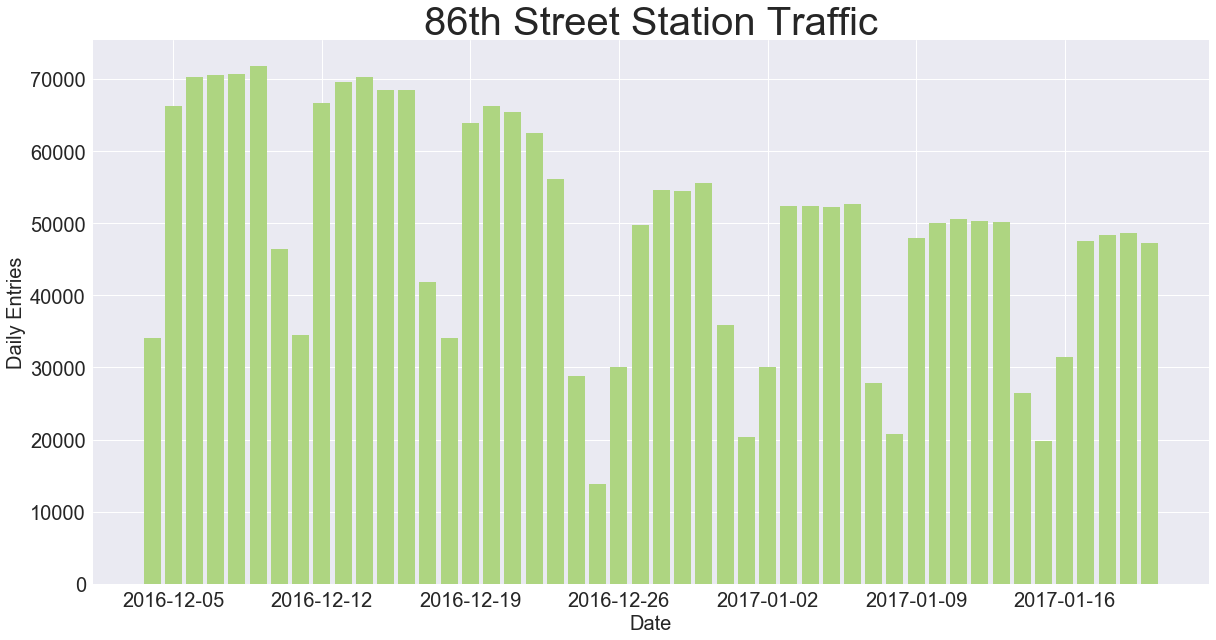

In [248]:
plt.figure(figsize = [20,10])
p1=plt.bar(df.index,df['86 ST'], color='#AED581')
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

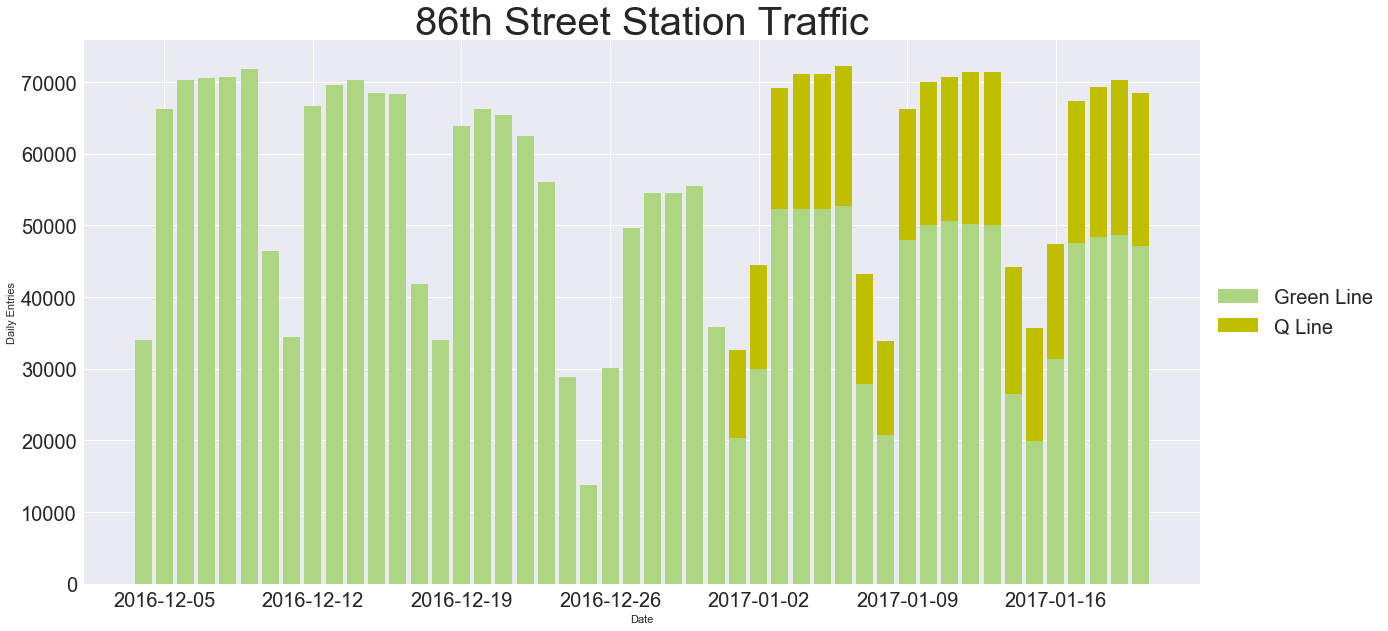

In [251]:
plt.figure(figsize = [20,10])
p1 = plt.bar(df.index,df['86 ST'], color='#AED581')
p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

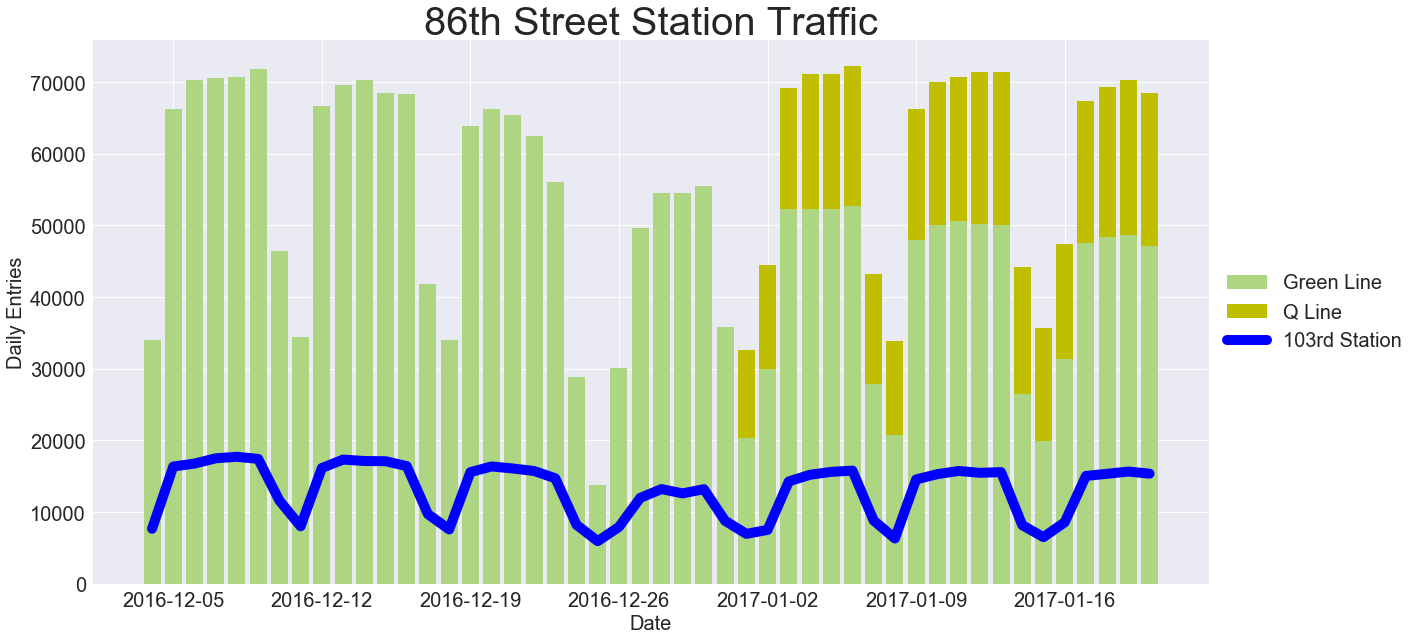

In [263]:
plt.figure(figsize = [20,10])
p1 = plt.bar(df.index,df['86 ST'], color='#AED581')
p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
p3 = plt.plot(df.index,df['103 ST'],color='b', linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

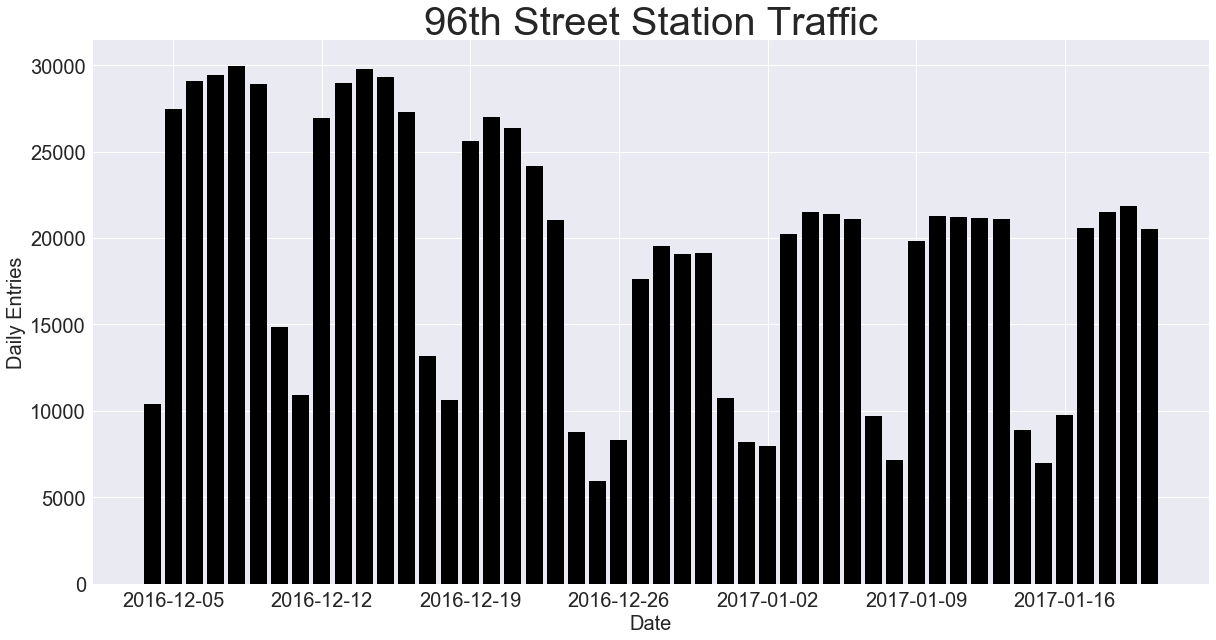

In [254]:
plt.figure(figsize = [20,10])
p1=plt.bar(df.index,df['96 ST'], color='black')
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

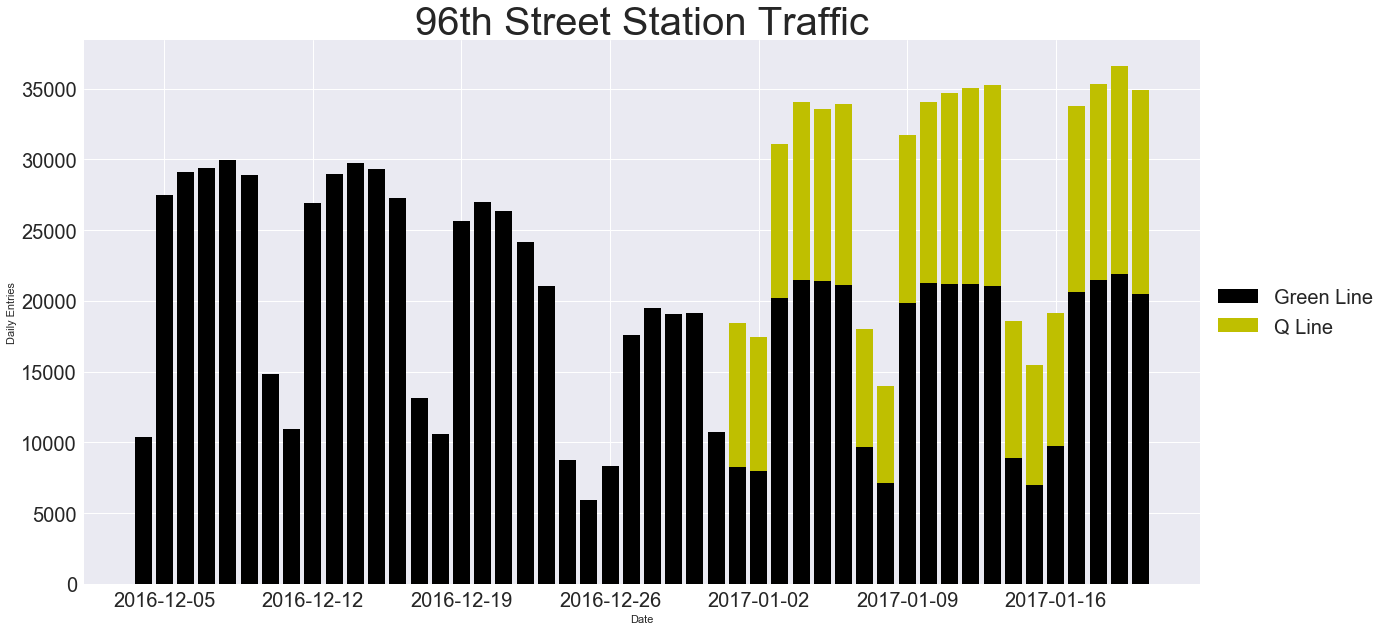

In [255]:
plt.figure(figsize = [20,10])
p1 = plt.bar(df.index,df['96 ST'], color='black')
p2 = plt.bar(df.index,df['96 ST-2 AVE'], bottom=df['96 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

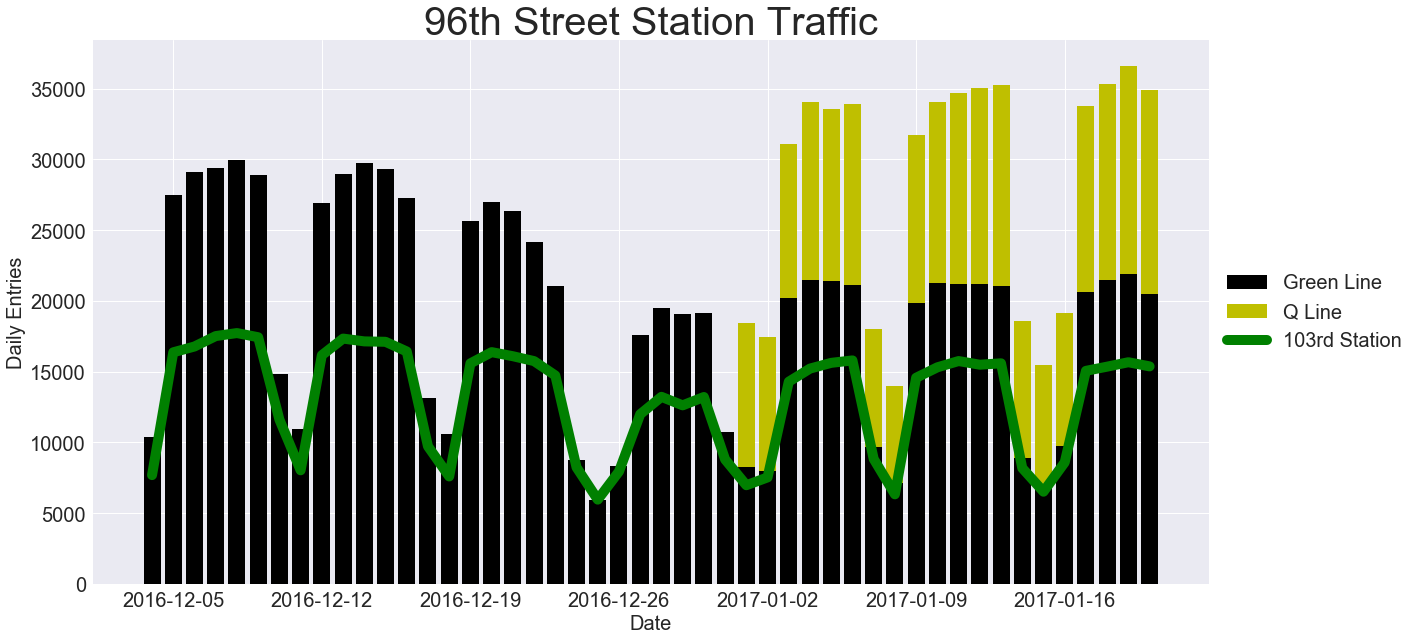

In [262]:
plt.figure(figsize = [20,10])
p1 = plt.bar(df.index,df['96 ST'], color='black')
p2 = plt.bar(df.index,df['96 ST-2 AVE'], bottom=df['96 ST'],color='y')
p3 = plt.plot(df.index,df['103 ST'],color='green',linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

# Weekly Graphs Now

In [238]:
df_weekly=pd.DataFrame(dailyStations.groupby(['station', 'linename', pd.Grouper(key='date', freq='W-SAT')])['daily_entries']
       .sum()
       .reset_index()
       .sort_values('date'))

In [283]:
weeklypivot = pd.DataFrame(df_weekly.pivot(index='date', columns='station')['daily_entries'])

In [243]:
weeklypivot.index

DatetimeIndex(['2016-12-10', '2016-12-17', '2016-12-24', '2016-12-31',
               '2017-01-07', '2017-01-14', '2017-01-21'],
              dtype='datetime64[ns]', name='date', freq=None)

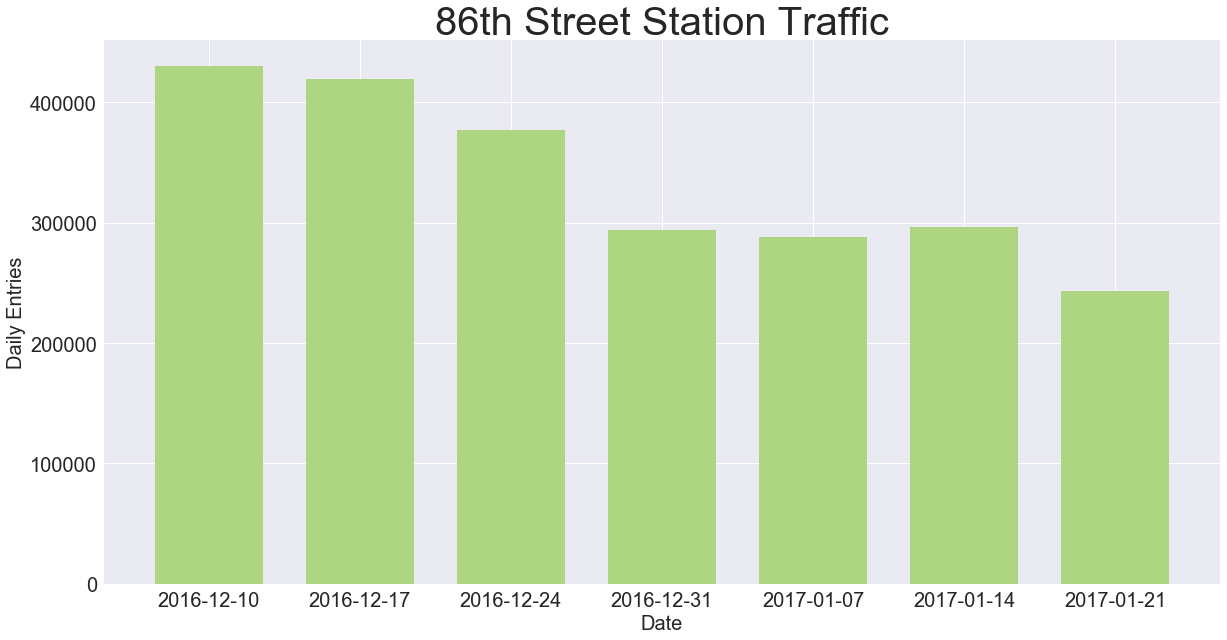

In [267]:
plt.figure(figsize = [20,10])
p1=plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#AED581',width=5)
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

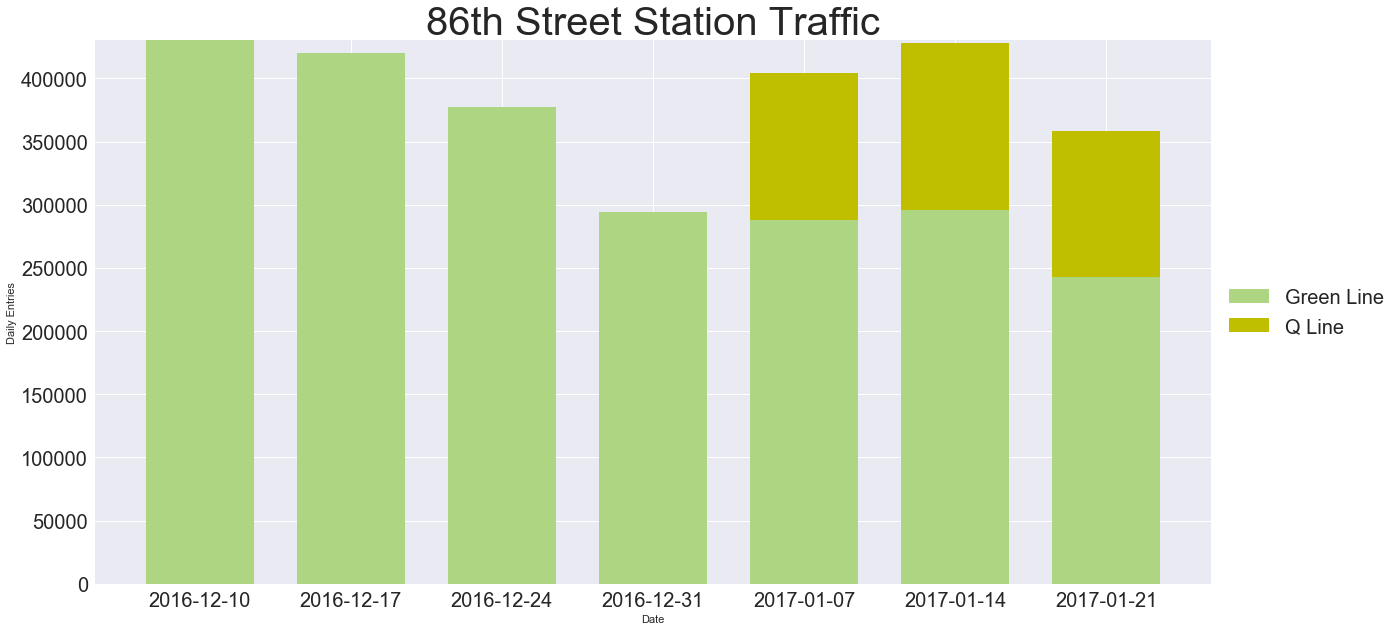

In [272]:
plt.figure(figsize = [20,10])
p1 = plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#AED581',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['86 ST-2 AVE'], bottom=weeklypivot['86 ST'],color='y',width=5)
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

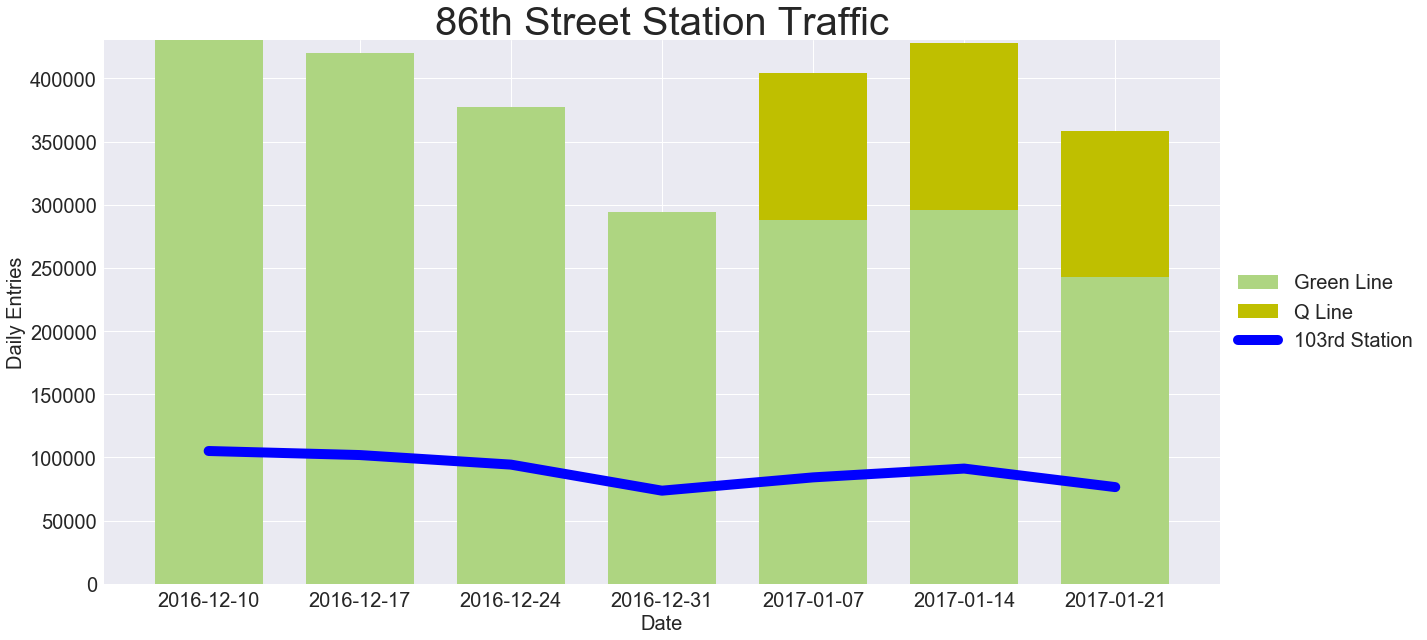

In [276]:
plt.figure(figsize = [20,10])
p1 = plt.bar(weeklypivot.index,weeklypivot['86 ST'], color='#AED581',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['86 ST-2 AVE'], bottom=weeklypivot['86 ST'],color='y',width=5)
p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='b', linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

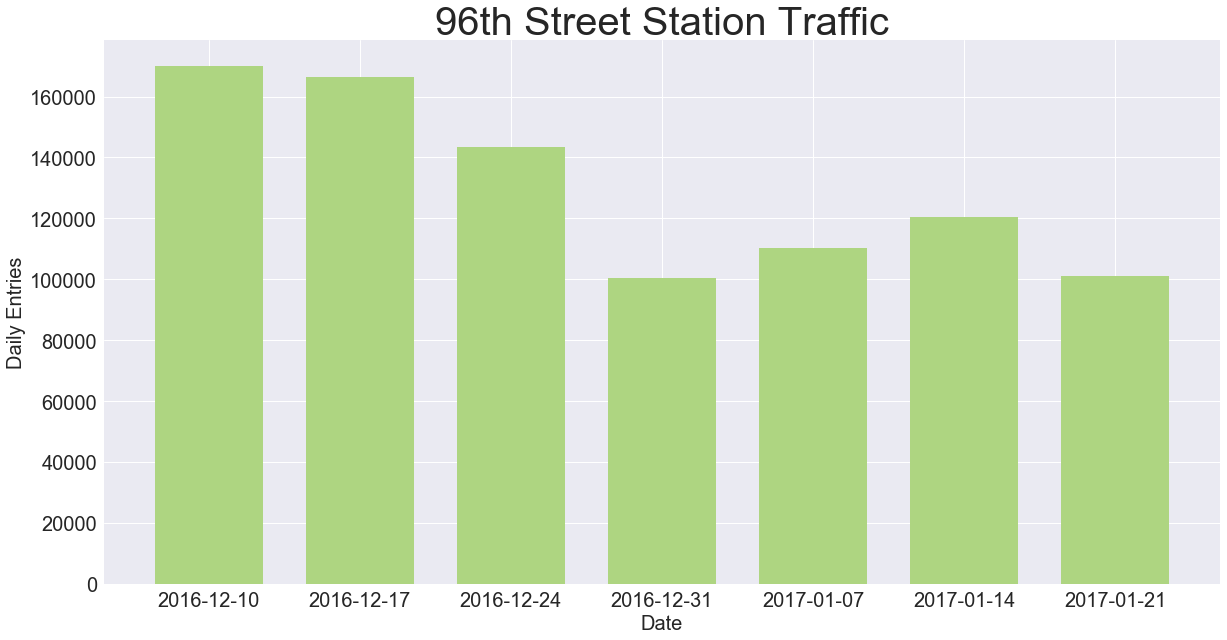

In [300]:
plt.figure(figsize = [20,10])
p1=plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#AED581',width=5)
#p2 = plt.bar(df.index,df['86 ST-2 AVE'], bottom=df['86 ST'],color='y')
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40');

#plt.legend('456 Station',loc='center left', bbox_to_anchor=(1, 0.5));

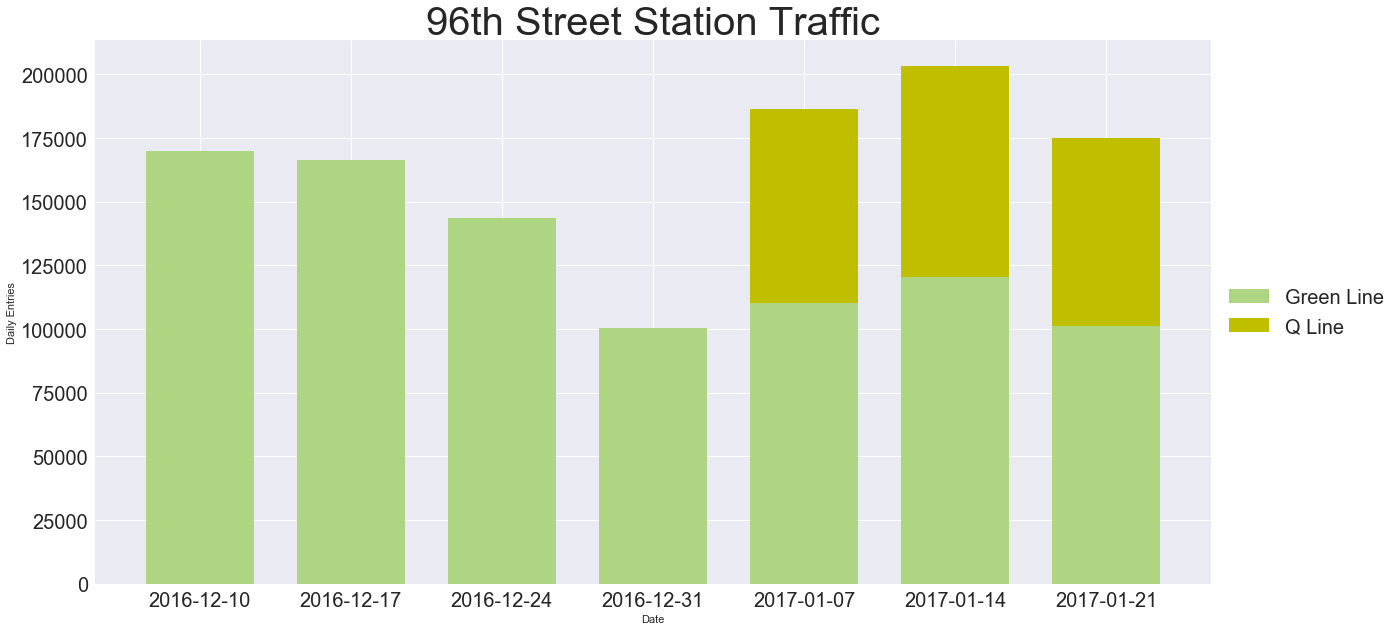

In [301]:
plt.figure(figsize = [20,10])
p1 = plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#AED581',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['96 ST-2 AVE'], bottom=weeklypivot['96 ST'],color='y',width=5)
#p3 = plt.plot(df.index,df['103 ST'],color='b')
plt.xlabel('Date')
plt.ylabel('Daily Entries')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic", fontsize='40')


plt.legend((p1[0],p2[0]),('Green Line','Q Line'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

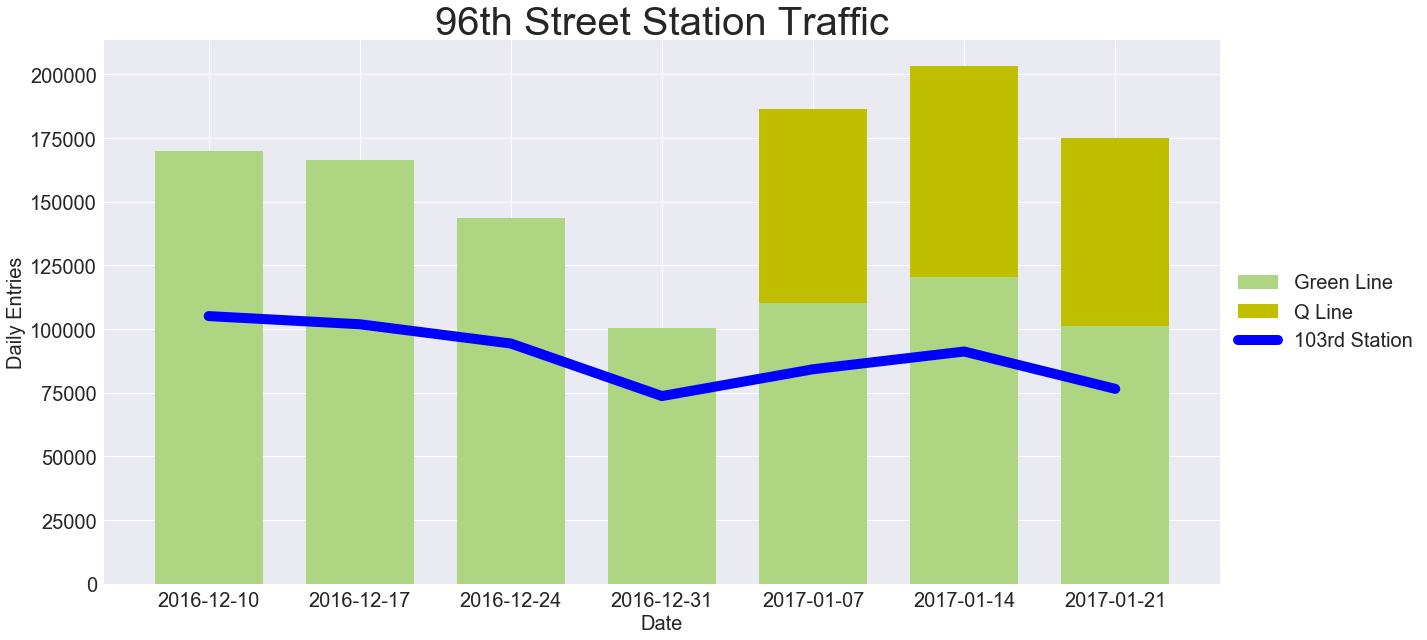

In [302]:
plt.figure(figsize = [20,10])
p1 = plt.bar(weeklypivot.index,weeklypivot['96 ST'], color='#AED581',width=5)
p2 = plt.bar(weeklypivot.index,weeklypivot['96 ST-2 AVE'], bottom=weeklypivot['96 ST'],color='y',width=5)
p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='b', linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('Green Line','Q Line','103rd Station'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

In [284]:
weeklypivot=weeklypivot.fillna(0)
weeklypivot['total_86']=weeklypivot['86 ST'] + weeklypivot['86 ST-2 AVE']
weeklypivot['total_96']=weeklypivot['96 ST'] + weeklypivot['96 ST-2 AVE']

In [285]:
weeklypivot

station,103 ST,110 ST,77 ST,86 ST,86 ST-2 AVE,96 ST,96 ST-2 AVE,total_86,total_96
date,,,,,,,,,
2016-12-10,105091.0,83559.0,240985.0,430194.0,0.0,169992.0,0.0,430194.0,169992.0
2016-12-17,101890.0,81160.0,235239.0,419772.0,0.0,166330.0,0.0,419772.0,166330.0
2016-12-24,94328.0,77241.0,205277.0,376967.0,0.0,143536.0,0.0,376967.0,143536.0
2016-12-31,73697.0,59278.0,158968.0,294074.0,0.0,100347.0,0.0,294074.0,100347.0
2017-01-07,84220.0,69549.0,168749.0,287900.0,116022.0,110107.0,76354.0,403922.0,186461.0
2017-01-14,91185.0,76197.0,178614.0,296172.0,131750.0,120598.0,82635.0,427922.0,203233.0
2017-01-21,76522.0,64374.0,150404.0,243040.0,115414.0,101196.0,73991.0,358454.0,175187.0


In [292]:
Constant103 = weeklypivot['103 ST'][0]
Constant86 = weeklypivot['total_86'][0]
Constant96 = weeklypivot['total_96'][0]
weeklypivot['103rd_Change'] = (weeklypivot['103 ST']/Constant103)-1
weeklypivot['86th_Change'] = (weeklypivot['total_86']/Constant86)-1
weeklypivot['96th_Change'] = (weeklypivot['total_96']/Constant96)-1


In [293]:
weeklypivot

station,103 ST,110 ST,77 ST,86 ST,86 ST-2 AVE,96 ST,96 ST-2 AVE,total_86,total_96,103rd_Change,86th_Change,96th_Change
date,,,,,,,,,,,,
2016-12-10,105091.0,83559.0,240985.0,430194.0,0.0,169992.0,0.0,430194.0,169992.0,0.000000,0.000000,0.000000
2016-12-17,101890.0,81160.0,235239.0,419772.0,0.0,166330.0,0.0,419772.0,166330.0,-0.030459,-0.024226,-0.021542
2016-12-24,94328.0,77241.0,205277.0,376967.0,0.0,143536.0,0.0,376967.0,143536.0,-0.102416,-0.123728,-0.155631
2016-12-31,73697.0,59278.0,158968.0,294074.0,0.0,100347.0,0.0,294074.0,100347.0,-0.298732,-0.316415,-0.409696
2017-01-07,84220.0,69549.0,168749.0,287900.0,116022.0,110107.0,76354.0,403922.0,186461.0,-0.198599,-0.061070,0.096881
2017-01-14,91185.0,76197.0,178614.0,296172.0,131750.0,120598.0,82635.0,427922.0,203233.0,-0.132323,-0.005281,0.195544
2017-01-21,76522.0,64374.0,150404.0,243040.0,115414.0,101196.0,73991.0,358454.0,175187.0,-0.271850,-0.166762,0.030560


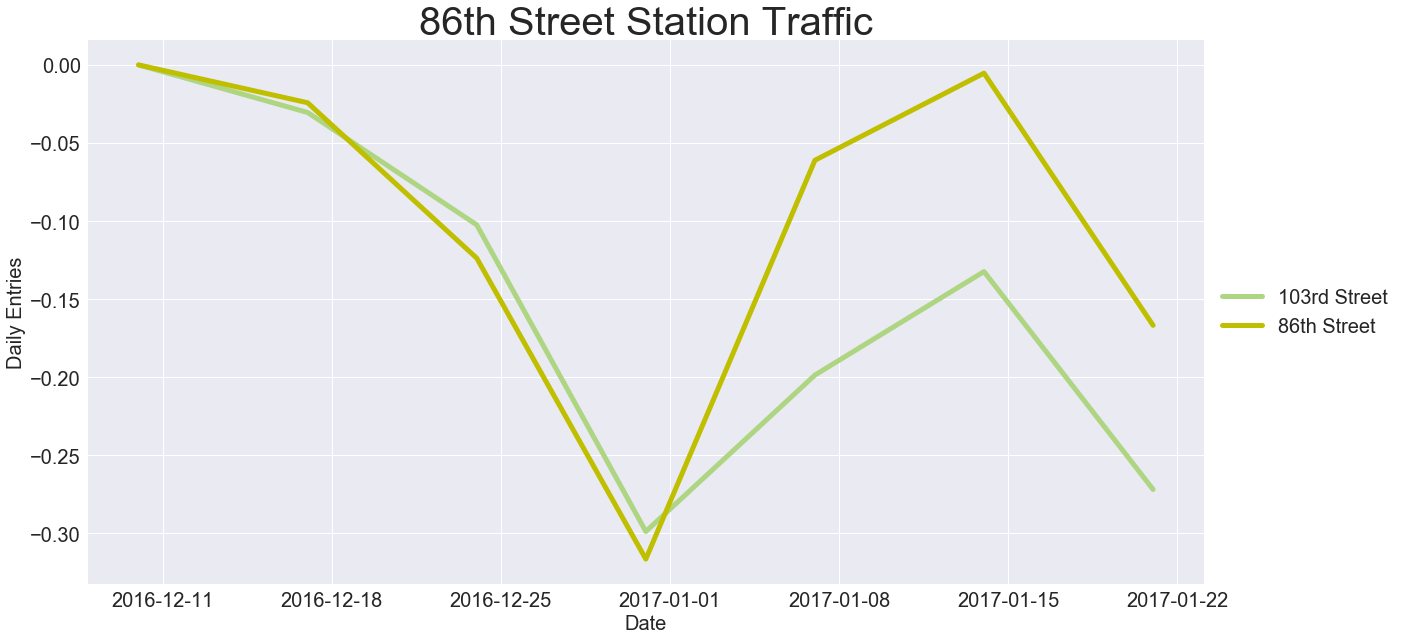

In [298]:
plt.figure(figsize = [20,10])
p1 = plt.plot(weeklypivot.index,weeklypivot['103rd_Change'], color='#AED581',linewidth=5)
p2 = plt.plot(weeklypivot.index,weeklypivot['86th_Change'],color='y',linewidth=5)
#p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='b', linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("86th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('103rd Street','86th Street'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');

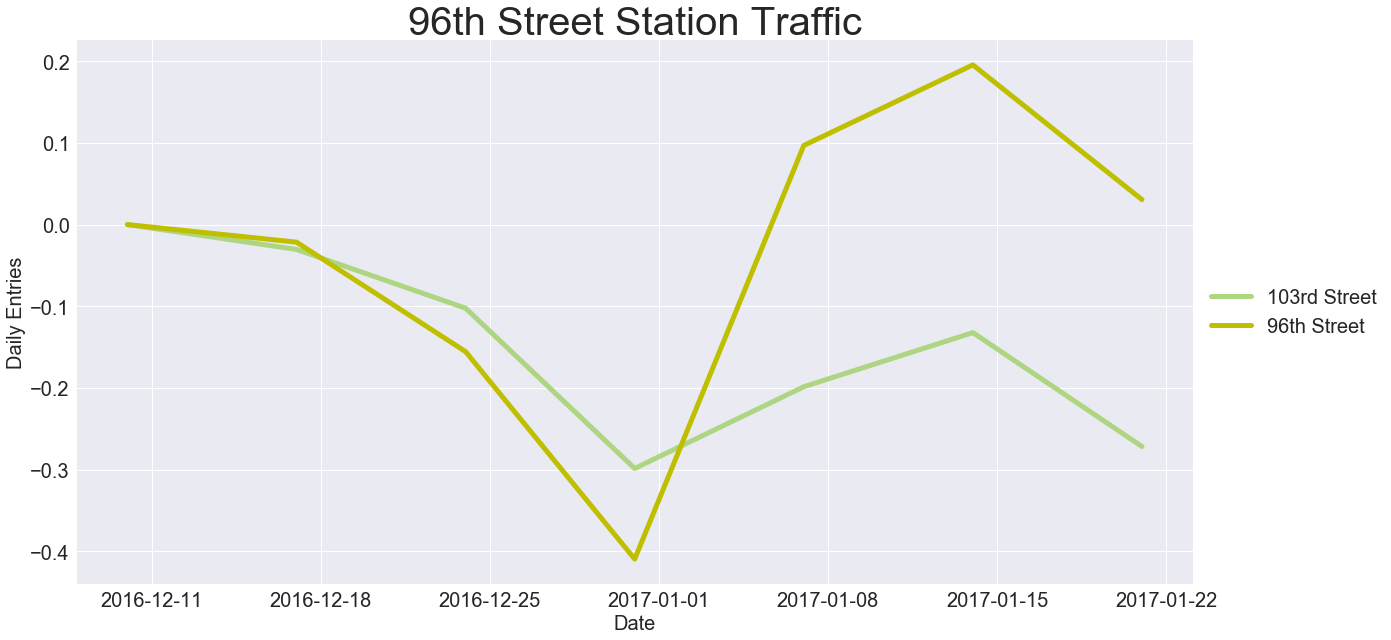

In [304]:
plt.figure(figsize = [20,10])
p1 = plt.plot(weeklypivot.index,weeklypivot['103rd_Change'], color='#AED581',linewidth=5)
p2 = plt.plot(weeklypivot.index,weeklypivot['96th_Change'],color='y',linewidth=5)
#p3 = plt.plot(weeklypivot.index,weeklypivot['103 ST'],color='b', linewidth='10')
plt.xlabel('Date', fontsize='20')
plt.ylabel('Daily Entries', fontsize='20')
plt.xticks(fontsize='20')
plt.yticks(fontsize='20')
plt.title("96th Street Station Traffic",fontsize='40')


plt.legend((p1[0],p2[0],p3[0]),('103rd Street','96th Street'),loc='center left', bbox_to_anchor=(1, 0.5),fontsize='20');